<a href="https://colab.research.google.com/github/dataskeptic/similarities/blob/main/similarities_biology_lemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download pt_core_news_lg

In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

In [4]:
import spacy
nlp = spacy.load('pt_core_news_lg')

In [191]:
def to_lowercase(data):
    return data.str.lower()

def remove_punct(data):
    return data.str.replace(r'[^\w\s]', ' ', regex=True)

def remove_stopwords(text):
    stop_words = set(stopwords.words('portuguese'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text, language='portuguese')
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

def stem(text):
    stemmer = SnowballStemmer('portuguese')
    tokens = word_tokenize(text, language='portuguese')
    return ' '.join([stemmer.stem(token) for token in tokens])

def preprocess_text(data):
    data = remove_punct(data)
    data = to_lowercase(data)
    data = data.apply(remove_stopwords)
    data = data.apply(lemmatize)
    #data = data.apply(stem)
    return data


In [211]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

path_reference_answers = "drive/MyDrive/data/biology/reference_answers_extended.xlsx"
path_student_answers = "drive/MyDrive/data/biology/student_answers.xlsx"

reference_answers = pd.read_excel(path_reference_answers)
student_answers = pd.read_excel(path_student_answers)

print(reference_answers.head())
print("---------------------------------------")
print(student_answers)

   question_id                                        refans_text
0            1  A célula animal possui formato irregular e a c...
1            1  Nos vegetais, a célula apresenta, além da memb...
2            1  na celula vegetal há cloroplasto, parede celul...
3            1  A célula animal e vegetal apresentam formato d...
4            1  As células animais são todas aquelas que compõ...
---------------------------------------
      question_id                                        answer_text  grade
0               1               A animal têm núcleo e o vegetal não.      0
1               1                       uma têm núcleo e a outra não      0
2               1          animal têm núcleo o animal não têm núcleo      0
3               1                           uma têm núcleo outra não      0
4               1  A célula animal é composta por apenas uma célu...      0
...           ...                                                ...    ...
7100           15  É um processo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

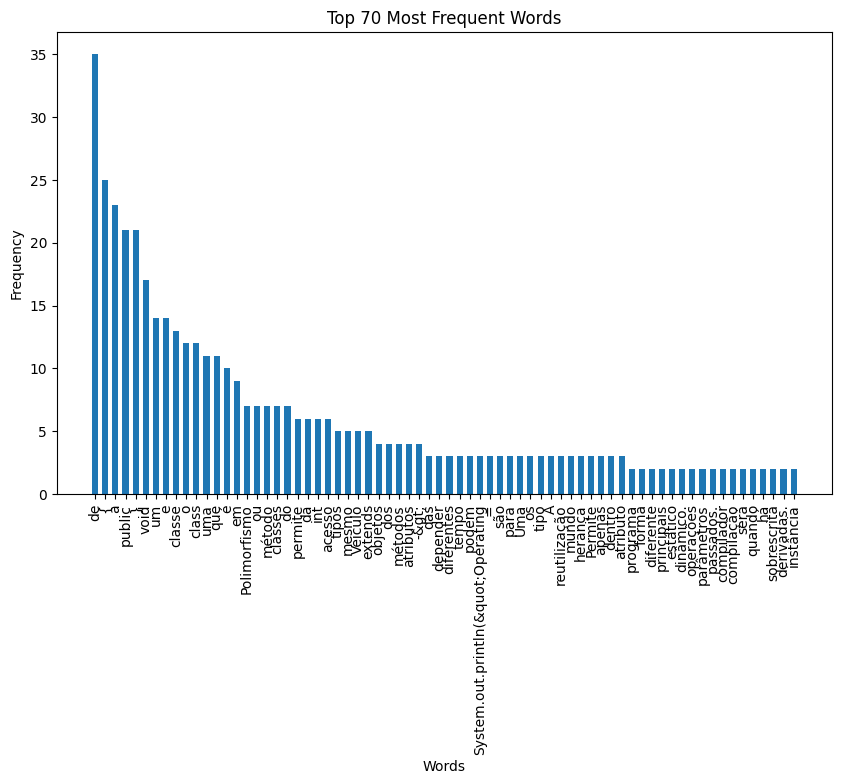

In [13]:
all_words = [word for tokens in reference_answers['refans_text'] for word in tokens.split()]
word_frequency = Counter(all_words)
most_common_words = word_frequency.most_common()

top_n = 70  # You can adjust the number of most frequent words to plot
words, frequencies = zip(*most_common_words[:top_n])
plt.figure(figsize=(10, 6))

plt.bar(words, frequencies,width=0.6)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Most Frequent Words'.format(top_n))
plt.xticks(rotation=90)
plt.show()

In [212]:
reference_answers['refans_preprocess'] = preprocess_text(reference_answers['refans_text'])

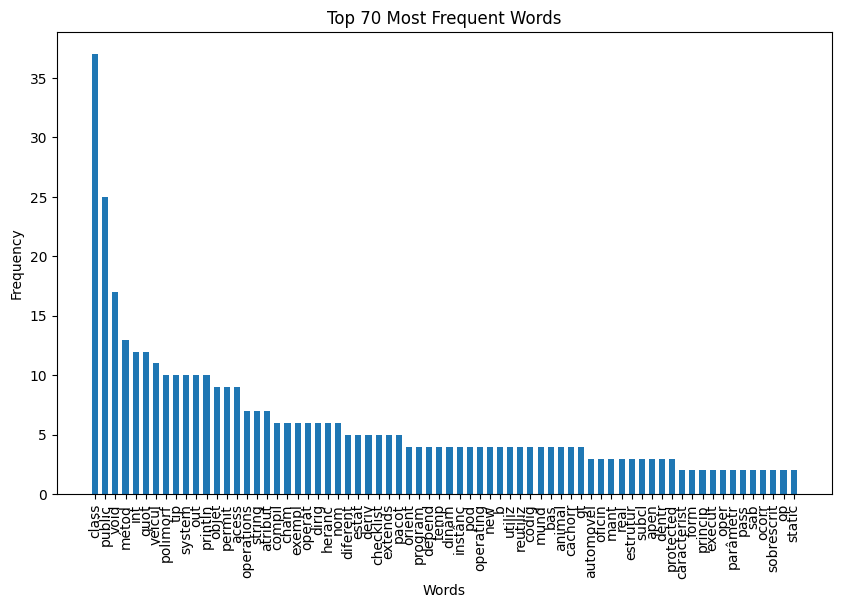

In [15]:
all_words = [word for tokens in reference_answers['refans_preprocess'] for word in tokens.split()]
word_frequency = Counter(all_words)
most_common_words = word_frequency.most_common()

top_n = 70  # You can adjust the number of most frequent words to plot
words, frequencies = zip(*most_common_words[:top_n])
plt.figure(figsize=(10, 6))

plt.bar(words, frequencies,width=0.6)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Most Frequent Words'.format(top_n))
plt.xticks(rotation=90)
plt.show()

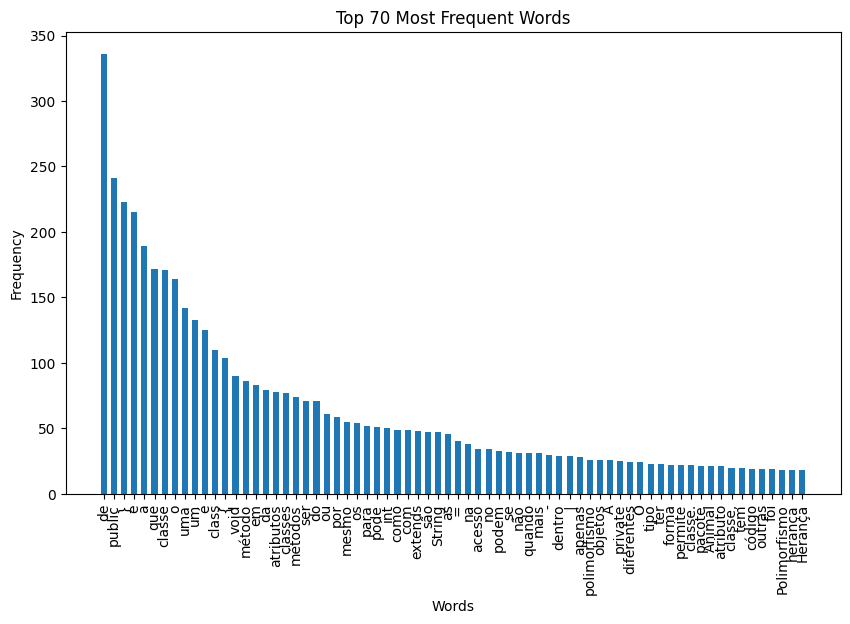

In [16]:
all_words = [word for tokens in student_answers['answer_text'] for word in tokens.split()]
word_frequency = Counter(all_words)
most_common_words = word_frequency.most_common()

top_n = 70  # You can adjust the number of most frequent words to plot
words, frequencies = zip(*most_common_words[:top_n])
plt.figure(figsize=(10, 6))

plt.bar(words, frequencies,width=0.6)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Most Frequent Words'.format(top_n))
plt.xticks(rotation=90)
plt.show()

In [213]:
student_answers['answer_text'] = student_answers['answer_text'].fillna('')

In [214]:
student_answers['answer_preprocess'] = preprocess_text(student_answers['answer_text'])

In [215]:
print(student_answers['answer_preprocess'])

0                               animal têm núcleo vegetal
1                                        têm núcleo outra
2                     animal têm núcleo animal têm núcleo
3                                        têm núcleo outra
4       célula animal composta apenas célula vegetal v...
                              ...                        
7100            processo onde máquina limpa filtra sangue
7101    funciona come om rim artificial serve filtrar ...
7102                        faz função rim filtrar sangue
7103    hemodiálise processo máquina limpa filtra sang...
7104                   procedimento filtra sangue rim faz
Name: answer_preprocess, Length: 7105, dtype: object


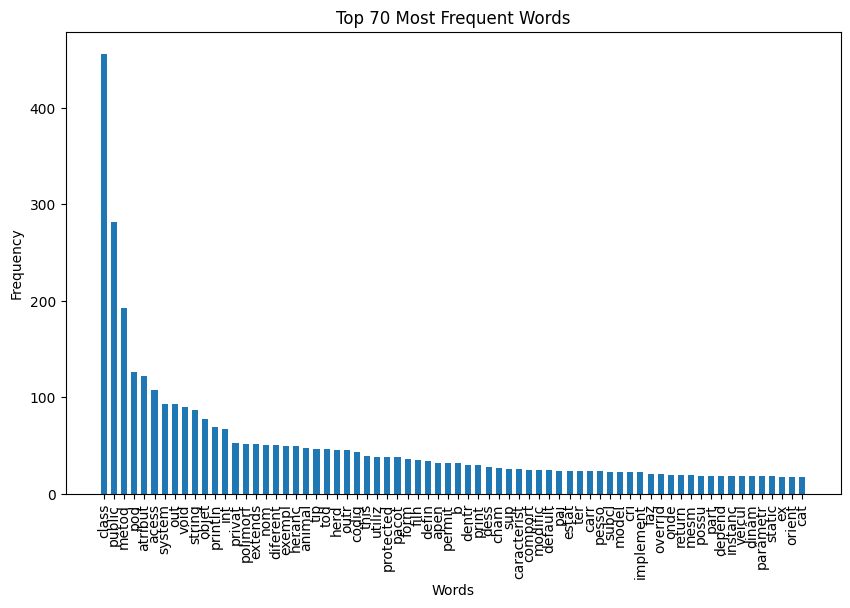

In [20]:
all_words = [word for tokens in student_answers['answer_preprocess'] for word in tokens.split()]
word_frequency = Counter(all_words)
most_common_words = word_frequency.most_common()

top_n = 70  # You can adjust the number of most frequent words to plot
words, frequencies = zip(*most_common_words[:top_n])
plt.figure(figsize=(10, 6))

plt.bar(words, frequencies,width=0.6)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Most Frequent Words'.format(top_n))
plt.xticks(rotation=90)
plt.show()

In [216]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tf_vectorizer = CountVectorizer()

In [217]:
tf_tfidf_similarities = pd.DataFrame()

for questionId in range(1, 5):
  temp_student_answers = student_answers[student_answers['question_id'] ==  questionId].copy()
  refans_tfidf = tfidf_vectorizer.fit_transform(reference_answers['refans_preprocess'][reference_answers['question_id'] == questionId].copy())
  refans_tf = tf_vectorizer.fit_transform(reference_answers['refans_preprocess'][reference_answers['question_id'] == questionId].copy())

  for index, row in temp_student_answers.iterrows():
    temp_answer_tfidf = tfidf_vectorizer.transform([temp_student_answers['answer_preprocess'][index]])
    temp_answer_tf = tf_vectorizer.transform([temp_student_answers['answer_preprocess'][index]])

    tfidf_cosine_similarity = ([(cosine_similarity(temp_answer_tfidf, ref_tfidf)[0][0]) for ref_tfidf in refans_tfidf])
    tf_cosine_similarity = ([(cosine_similarity(temp_answer_tf, ref_tf)[0][0]) for ref_tf in refans_tf])
    tfidf_similarities = max(tfidf_cosine_similarity), np.mean(tfidf_cosine_similarity), np.median(tfidf_cosine_similarity), min(tfidf_cosine_similarity)
    tf_similarities = max(tf_cosine_similarity), np.mean(tf_cosine_similarity), np.median(tf_cosine_similarity), min(tf_cosine_similarity)

    temp_student_answers.loc[index, ('max_cosine_tfidf', 'mean_cosine_tfidf', 'median_cosine_tfidf', 'min_cosine_tfidf')] = tfidf_similarities
    temp_student_answers.loc[index, ('max_cosine_tf', 'mean_cosine_tf', 'median_cosine_tf', 'min_cosine_tf')] = tf_similarities

  tf_tfidf_similarities = pd.concat([tf_tfidf_similarities, temp_student_answers])
print(tf_tfidf_similarities[['max_cosine_tfidf', 'mean_cosine_tfidf', 'median_cosine_tfidf', 'min_cosine_tfidf']])
print(tf_tfidf_similarities[['max_cosine_tf', 'mean_cosine_tf', 'median_cosine_tf', 'min_cosine_tf']])

      max_cosine_tfidf  mean_cosine_tfidf  median_cosine_tfidf  \
0             0.307986           0.133382             0.131258   
1             0.221163           0.027645             0.000000   
2             0.211156           0.086626             0.058618   
3             0.221163           0.027645             0.000000   
4             0.684256           0.250476             0.188296   
...                ...                ...                  ...   
2040          0.423106           0.229595             0.211024   
2041          0.357480           0.149181             0.160640   
2042          1.000000           0.199766             0.089285   
2043          0.688596           0.179079             0.124595   
2044          0.297846           0.146544             0.159660   

      min_cosine_tfidf  
0             0.000000  
1             0.000000  
2             0.000000  
3             0.000000  
4             0.000000  
...                ...  
2040          0.066815  
2041   

In [218]:
def jaccard_similarity(sentence1, sentence2):
    # Tokenize the sentences
    set1 = set(sentence1.split())
    set2 = set(sentence2.split())

    # Calculate intersection and union of the two sets
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    # Calculate Jaccard similarity
    return intersection / union if union != 0 else 0

In [219]:
jaccard_similarities = pd.DataFrame()

for questionId in range(1, 16):
  temp_student_answers = student_answers[student_answers['question_id'] ==  questionId].copy()
  refans = reference_answers['refans_preprocess'][reference_answers['question_id'] == questionId].copy()

  for index, row in temp_student_answers.iterrows():
    temp_answer = temp_student_answers['answer_preprocess'][index]
    jaccard_scores = ([(jaccard_similarity(temp_answer, ref)) for ref in refans])
    similarities = max(jaccard_scores),  np.mean(jaccard_scores), np.median(jaccard_scores), min(jaccard_scores)
    temp_student_answers.loc[index, ('max_jaccard', 'mean_jaccard', 'median_jaccard', 'min_jaccard')] = similarities

  jaccard_similarities = pd.concat([jaccard_similarities, temp_student_answers])
print(jaccard_similarities[['max_jaccard', 'mean_jaccard', 'median_jaccard', 'min_jaccard']])

      max_jaccard  mean_jaccard  median_jaccard  min_jaccard
0        0.142857      0.065223        0.066288     0.000000
1        0.041667      0.005208        0.000000     0.000000
2        0.071429      0.027034        0.020833     0.000000
3        0.041667      0.005208        0.000000     0.000000
4        0.200000      0.081398        0.078462     0.000000
...           ...           ...             ...          ...
7100     0.333333      0.160419        0.167832     0.000000
7101     0.400000      0.156031        0.150000     0.000000
7102     0.555556      0.295263        0.309524     0.000000
7103     0.529412      0.208850        0.177083     0.041667
7104     0.500000      0.301948        0.309524     0.000000

[7105 rows x 4 columns]


In [220]:
tok2vec_similarities = pd.DataFrame()

for questionId in range(1, 16):
  temp_student_answers = student_answers[student_answers['question_id'] ==  questionId].copy()
  refans_tok2vec = (reference_answers['refans_preprocess'][reference_answers['question_id'] == questionId].copy())
  refans_tok2vec = [nlp(ref) for ref in refans_tok2vec]

  for index, row in temp_student_answers.iterrows():

    temp_answer_tok2vec = nlp(temp_student_answers['answer_preprocess'][index])

    tok2vec_cosine_similarity = ([temp_answer_tok2vec.similarity(ref_tok2vec) for ref_tok2vec in refans_tok2vec])
    similarities = max(tok2vec_cosine_similarity), np.mean(tok2vec_cosine_similarity), np.median(tok2vec_cosine_similarity), min(tok2vec_cosine_similarity)

    temp_student_answers.loc[index, ('max_cosine_tok2vec', 'mean_cosine_tok2vec', 'median_cosine_tok2vec', 'min_cosine_tok2vec')] = similarities

  tok2vec_similarities = pd.concat([tok2vec_similarities, temp_student_answers])
print(tok2vec_similarities[['max_cosine_tok2vec', 'mean_cosine_tok2vec', 'median_cosine_tok2vec', 'min_cosine_tok2vec']])

<ipython-input-220-411890e2e4e4>:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  tok2vec_cosine_similarity = ([temp_answer_tok2vec.similarity(ref_tok2vec) for ref_tok2vec in refans_tok2vec])
<ipython-input-220-411890e2e4e4>:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  tok2vec_cosine_similarity = ([temp_answer_tok2vec.similarity(ref_tok2vec) for ref_tok2vec in refans_tok2vec])
<ipython-input-220-411890e2e4e4>:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  tok2vec_cosine_similarity = ([temp_answer_tok2vec.similarity(ref_tok2vec) for ref_tok2vec in refans_tok2vec])
<ipython-input-220-411890e2e4e4>:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  tok2vec_cosine_similarity = ([temp_answer_tok2vec.similarity(ref_tok2vec) for ref_tok2vec in refans_tok2vec])
<ipython-input-220-411890e2e4e4>:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  tok2vec_cosine_

      max_cosine_tok2vec  mean_cosine_tok2vec  median_cosine_tok2vec  \
0               0.620362             0.502089               0.531132   
1               0.444921             0.371719               0.421306   
2               0.504411             0.395728               0.434785   
3               0.444921             0.371719               0.421306   
4               0.882325             0.799792               0.811056   
...                  ...                  ...                    ...   
7100            0.784906             0.691050               0.691207   
7101            0.823575             0.770687               0.781621   
7102            0.922717             0.832793               0.832484   
7103            0.945996             0.842763               0.840052   
7104            0.926031             0.826146               0.832577   

      min_cosine_tok2vec  
0               0.313610  
1               0.201658  
2               0.230370  
3               0.201658  


In [221]:
dfs = [tok2vec_similarities, jaccard_similarities, tf_tfidf_similarities]
similarities = pd.concat(dfs, axis=1)

# Remover colunas duplicadas (se necessário)
similarities = similarities.loc[:, ~similarities.columns.duplicated()]

print(similarities)

      question_id                                        answer_text  grade  \
0               1               A animal têm núcleo e o vegetal não.      0   
1               1                       uma têm núcleo e a outra não      0   
2               1          animal têm núcleo o animal não têm núcleo      0   
3               1                           uma têm núcleo outra não      0   
4               1  A célula animal é composta por apenas uma célu...      0   
...           ...                                                ...    ...   
7100           15  É um processo onde uma máquina limpa a filtra ...      3   
7101           15  Funciona come om rim artificial. Serve para fi...      3   
7102           15       Faz a função do rim, que é filtrar o sangue.      3   
7103           15  A hemodiálise é um processo na qual uma máquin...      3   
7104           15  Um procedimento que filtra o sangue quando o r...      3   

                                      answer_prepro

In [222]:
similarity_columns = [col for col in similarities.columns[4:]]
statistics = similarities[similarity_columns].describe()
statistics

,max_cosine_tok2vec,mean_cosine_tok2vec,median_cosine_tok2vec,min_cosine_tok2vec,max_jaccard,mean_jaccard,median_jaccard,min_jaccard,max_cosine_tfidf,mean_cosine_tfidf,median_cosine_tfidf,min_cosine_tfidf,max_cosine_tf,mean_cosine_tf,median_cosine_tf,min_cosine_tf
count,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000
mean,0.811351,0.723650,0.732309,0.600621,0.203857,0.094837,0.084641,0.021447,0.424568,0.175229,0.151009,0.022068,0.509919,0.259457,0.257953,0.047106
std,0.130687,0.136365,0.139554,0.152528,0.165605,0.070936,0.067399,0.033938,0.182664,0.075253,0.085664,0.034060,0.196037,0.119680,0.145000,0.063666
min,-0.060205,-0.130809,-0.161470,-0.234301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.759956,0.671630,0.676954,0.528053,0.100000,0.039489,0.031250,0.000000,0.306236,0.125342,0.096132,0.000000,0.400892,0.172685,0.167103,0.000000
50%,0.839282,0.754652,0.763997,0.629366,0.166667,0.082212,0.077126,0.000000,0.409732,0.178984,0.159765,0.000000,0.520573,0.274962,0.268729,0.000000
75%,0.896550,0.814077,0.824569,0.706466,0.264706,0.139740,0.129371,0.040000,0.532774,0.237161,0.210567,0.035226,0.648886,0.357469,0.364201,0.089443
max,1.000000,0.950266,0.969722,0.889354,1.000000,0.397590,0.399614,0.218750,1.000000,0.328986,0.378050,0.187527,1.000000,0.473966,0.597363,0.282843


In [223]:
def similarity_to_score(similarity):
    median = similarities[f'{column_name}'].median()
    std = similarities[f'{column_name}'].std()
    lower_bound = (median - std)
    upper_bound = (median + std)
    if similarity < lower_bound:
        return 0
    elif similarity > upper_bound:
        return 3
    else:
        # For values between lower_bound and upper_bound
        distance_to_lower = abs(similarity - lower_bound)
        distance_to_upper = abs(similarity - upper_bound)

        # If similarity is closer to the lower_bound, return 1, otherwise return 2
        return 1 if distance_to_lower < distance_to_upper else 2

for column_name in similarities.columns[4:]:
    similarities[f'{column_name}_grade'] = similarities[f'{column_name}'].apply(lambda sim: similarity_to_score(sim))

In [227]:
def similarity_to_score(similarity):
    if similarity <= 0.3 :
        score = 0
    elif similarity <= 0.6:
        score = 1
    elif similarity <= 0.9:
        score = 2
    else:
        score = 3
    return score

#similarities['grade'] = similarities['notas'].apply(similarity_to_score)
similarities['grade'].value_counts()

1    2391
0    1968
2    1751
3     995
Name: grade, dtype: int64

In [226]:
grade_columns = [col for col in similarities.columns if col.endswith('grade')]

grade_similarities = similarities[grade_columns]

# Show frequencies for each 'grade' column
for col in grade_similarities.columns:
    print(f"Frequencies for {col}:")
    print(grade_similarities[col].value_counts())
    print("\n")

Frequencies for grade:
1    2391
0    1968
2    1751
3     995
Name: grade, dtype: int64


Frequencies for max_cosine_tok2vec_grade:
2    3346
1    2460
0    1092
3     207
Name: max_cosine_tok2vec_grade, dtype: int64


Frequencies for mean_cosine_tok2vec_grade:
2    3442
1    2434
0    1118
3     111
Name: mean_cosine_tok2vec_grade, dtype: int64


Frequencies for median_cosine_tok2vec_grade:
2    3382
1    2412
0    1136
3     175
Name: median_cosine_tok2vec_grade, dtype: int64


Frequencies for min_cosine_tok2vec_grade:
2    3107
1    2329
0    1223
3     446
Name: min_cosine_tok2vec_grade, dtype: int64


Frequencies for max_jaccard_grade:
1    2887
2    2564
3    1151
0     503
Name: max_jaccard_grade, dtype: int64


Frequencies for mean_jaccard_grade:
1    2803
2    2063
3    1491
0     748
Name: mean_jaccard_grade, dtype: int64


Frequencies for median_jaccard_grade:
1    2136
2    2134
3    1418
0    1417
Name: median_jaccard_grade, dtype: int64


Frequencies for min_jaccard_grad

In [228]:
from sklearn.metrics import cohen_kappa_score

In [229]:
similarities_columns = [col for col in grade_similarities.columns if col.endswith('grade') and col != 'grade']

# Calculate Cohen's Kappa for each column with the reference 'grade' column
for col in similarities_columns:
    kappa_linear = cohen_kappa_score(grade_similarities[col], grade_similarities['grade'], weights='linear')
    kappa_quadratic = cohen_kappa_score(grade_similarities[col], grade_similarities['grade'], weights='quadratic')
    print(f"Linear {col}: {kappa_linear}")
    print(f"Quadratic {col}: {kappa_quadratic}")
    print()

Linear max_cosine_tok2vec_grade: 0.27947142517492696
Quadratic max_cosine_tok2vec_grade: 0.4092031662417247

Linear mean_cosine_tok2vec_grade: 0.24966651053531486
Quadratic mean_cosine_tok2vec_grade: 0.3809660417198536

Linear median_cosine_tok2vec_grade: 0.24369054470819418
Quadratic median_cosine_tok2vec_grade: 0.37485882410689064

Linear min_cosine_tok2vec_grade: 0.23315367347645766
Quadratic min_cosine_tok2vec_grade: 0.3425086340614495

Linear max_jaccard_grade: 0.2668332614308002
Quadratic max_jaccard_grade: 0.3849531751219415

Linear mean_jaccard_grade: 0.28232991290189335
Quadratic mean_jaccard_grade: 0.41784150822476185

Linear median_jaccard_grade: 0.2823425730559733
Quadratic median_jaccard_grade: 0.41711364083679603

Linear min_jaccard_grade: 0.02640540979124195
Quadratic min_jaccard_grade: 0.09804174337756288

Linear max_cosine_tfidf_grade: 0.052743618059559516
Quadratic max_cosine_tfidf_grade: 0.08208020194636167

Linear mean_cosine_tfidf_grade: 0.06714450189772025
Quadrat

In [230]:
similarities.to_excel('drive/MyDrive/data/results/similarities_biology_lemma.xlsx', index=False)